In [1]:
# Baseline: 11.3 iter/s
# Stagger 12.2 iter/s
# 1 and 2: 11.1 iter/s

In [2]:
import os
import numpy as np
import prettytensor as pt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from deconv import deconv2d
import IPython.display
import math
import tqdm
import h5py
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

%matplotlib inline  

In [3]:
## Parameters ###
dim1 = 64 # first dimension of input data
dim2 = 64 # second dimension of input data
dim3 = 3
batch_size = 32 # size of batches to use
hidden_size = 400 # size of hidden (z) layer to use
num_examples = 60000 # how many examples are in your training set
num_epochs = 10000 # number of epochs to run
e_learning_rate = 1e-3
g_learning_rate = 1e-3
d_learning_rate = 1e-3
gamma_param = 1

In [4]:
# set CUDA to only see one GPU
gpus = [1]
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use

In [5]:
# now reading the dataset is simple...
with h5py.File(''.join(['/mnt/cube/tsainbur/second_playground/celeba/faces_dataset_dim.h5']), 'r') as hf:
    faces = hf['images'].value
    headers = hf['headers'].value
    labels = hf['label_input'].value

In [73]:
def norm(x):
    return (x - np.min(x)) / np.max(x - np.min(x))

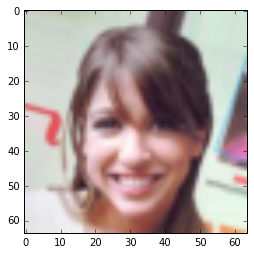

In [6]:
plt.imshow(np.reshape(faces[1]/255., (64,64,3)), cmap=plt.cm.gray)

In [7]:
#faces = np.reshape(faces, (len(faces), dim1,dim2,3))
#print np.shape(faces)
#faces = faces[:,:,:,0]
#print np.shape(faces)
#faces = np.reshape(faces, (len(faces),dim1*dim2))
#print np.shape(faces)

In [8]:
faces = faces/255.

In [9]:
def create_image(im):
    return np.reshape(im,(dim1,dim2,dim3))

In [10]:
test = faces[0].reshape(dim1,dim2,dim3)

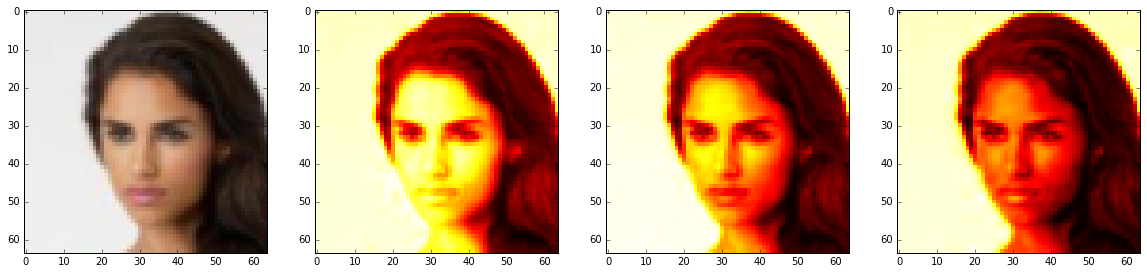

In [11]:
cm = plt.cm.hot
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(20,8))
ax[0].imshow(np.reshape(test, (dim1,dim2,dim3)), interpolation='nearest')
ax[1].imshow(np.reshape(test,(dim1,dim2,dim3))[:,:,0], interpolation='nearest', cmap=cm)
ax[2].imshow(np.reshape(test, (dim1,dim2,dim3))[:,:,1], interpolation='nearest', cmap=cm)
ax[3].imshow(np.reshape(test, (dim1,dim2,dim3))[:,:,2], interpolation='nearest', cmap=cm)

In [12]:
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        idxs = np.arange(0, len(faces))
        np.random.shuffle(idxs)
        for batch_idx in range(0, len(faces), batch_size):
            cur_idxs = idxs[batch_idx:batch_idx+batch_size]
            images_batch = faces[cur_idxs]
            #images_batch = images_batch.astype("float32")
            labels_batch = labels[cur_idxs]
            yield images_batch, labels_batch

            
iter_ = data_iterator()

In [13]:
conv1 = 128
conv2 = conv1*2
conv3 = conv2*2
conv4 = conv3*2

def encoder(X):
    '''Create encoder network.
    Args:
        x: a batch of flattened images [batch_size, 28*28]
    Returns:
        A tensor that expresses the encoder network
            # The transformation is parametrized and can be learned.
            # returns network output, mean, setd
    '''
    lay_end = (pt.wrap(X).
            reshape([batch_size, dim1, dim2, dim3]). 
            conv2d(5, conv1, stride=2). 
            conv2d(5, conv2, stride=2). 
            conv2d(5, conv3, stride=2). 
            conv2d(5, conv4, stride=2).
            flatten())
    z_mean = lay_end.fully_connected(hidden_size, activation_fn=None)
    z_log_sigma_sq = lay_end.fully_connected(hidden_size, activation_fn=None)
    return z_mean, z_log_sigma_sq


def generator(Z):
    '''Create generator network.
        If input tensor is provided then decodes it, otherwise samples from 
        a sampled vector.
    Args:
        x: a batch of vectors to decode
    Returns:
        A tensor that expresses the generator network
    '''
    return (pt.wrap(Z).
            fully_connected(4*4*conv4).reshape([batch_size, 4, 4, conv4]). #(128, 4 4, 256)
            deconv2d(5, conv3, stride=2).
            deconv2d(5, conv2, stride=2).
            deconv2d(5, conv1, stride=2).
            deconv2d(5, dim3, stride=2, activation_fn=tf.sigmoid).
            flatten()
           )

def discriminator(D_I):
    ''' A encodes
    Create a network that discriminates between images from a dataset and
    generated ones.
    Args:
        input: a batch of real images [batch, height, width, channels]
    Returns:
        A tensor that represents the network
    ''' 
    descrim_conv =  (pt.wrap(D_I). # This is what we're descriminating
            reshape([batch_size, dim1, dim2, dim3]).
            conv2d(5, conv1, stride=2). 
            conv2d(5, conv2, stride=2). 
            conv2d(5, conv3, stride=2). 
            conv2d(5, conv4, stride=2).
            flatten().fully_connected(1024).dropout(.8)
                )
    lth_layer= descrim_conv.fully_connected(1024, activation_fn=tf.nn.elu)# this is the lth layer       
    D =lth_layer.dropout(.8).fully_connected(1, activation_fn=tf.nn.sigmoid) # this is the actual discrimination
    return D, lth_layer


In [14]:
def inference(x):
    """
    Run the models. Called inference because it does the same thing as tensorflow's cifar tutorial
    """
    z_p =  tf.random_normal((batch_size, hidden_size), 0, 1) # normal dist for GAN
    eps = tf.random_normal((batch_size, hidden_size), 0, 1) # normal dist for VAE

    with pt.defaults_scope(activation_fn=tf.nn.elu,
                               batch_normalize=True,
                               learned_moments_update_rate=0.0003,
                               variance_epsilon=0.001,
                               scale_after_normalization=True):
        
        with tf.variable_scope("enc"):         
                z_x_mean, z_x_log_sigma_sq = encoder(x) # get z from the input      
        with tf.variable_scope("gen"):
            z_x = tf.add(z_x_mean, 
                tf.mul(tf.sqrt(tf.exp(z_x_log_sigma_sq)), eps)) # grab our actual z
            x_tilde = generator(z_x)  
        with tf.variable_scope("dis"):   
            _, l_x_tilde = discriminator(x_tilde)
        with tf.variable_scope("gen", reuse=True):         
            x_p = generator(z_p)    
        with tf.variable_scope("dis", reuse=True):
            d_x, l_x = discriminator(x)  # positive examples              
        with tf.variable_scope("dis", reuse=True):
            d_x_p, _ = discriminator(x_p)  
        return z_x_mean, z_x_log_sigma_sq, z_x, x_tilde, l_x_tilde, x_p, d_x, l_x, d_x_p, z_p

In [15]:
def loss(x, x_tilde, z_x_log_sigma_sq, z_x_mean, d_x, d_x_p, l_x, l_x_tilde, dim1, dim2, dim3):
    """
    Loss functions for SSE, KL divergence, Discrim, Generator, Lth Layer Similarity
    """
    ### We don't actually use SSE (MSE) loss for anything (but maybe pretraining)
    SSE_loss = tf.reduce_mean(tf.square(x - x_tilde)) # This is what a normal VAE uses

    # We clip gradients of KL divergence to prevent NANs
    KL_loss = tf.reduce_sum(-0.5 * tf.reduce_sum(1 + tf.clip_by_value(z_x_log_sigma_sq, -10.0, 10.0) 
                                   - tf.square(tf.clip_by_value(z_x_mean, -10.0, 10.0) ) 
                                   - tf.exp(tf.clip_by_value(z_x_log_sigma_sq, -10.0, 10.0) ), 1))/dim1/dim2/dim3
    # Discriminator Loss
    D_loss = tf.reduce_mean(-1.*(tf.log(tf.clip_by_value(d_x,1e-5,1.0)) + 
                                    tf.log(tf.clip_by_value(1.0 - d_x_p,1e-5,1.0))))
    # Generator Loss    
    G_loss = tf.reduce_mean(-1.*(tf.log(tf.clip_by_value(d_x_p,1e-5,1.0))))# + 
                                    #tf.log(tf.clip_by_value(1.0 - d_x,1e-5,1.0))))
    # Lth Layer Loss - the 'learned similarity measure'  
    LL_loss = tf.reduce_sum(tf.square(l_x - l_x_tilde))/dim1/dim2/dim3
    return SSE_loss, KL_loss, D_loss, G_loss, LL_loss

In [16]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
     
     
    ### THIS FUNCTION WAS TAKEN FROM TENSORFLOW TUTORIALS:
        https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/models/image/cifar10/cifar10_multi_gpu_train.py
    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(0, grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads


In [17]:
def sigmoid(x,shift,mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + math.exp(-(x+shift)*mult))

In [18]:
def plot_network_output():
    """ Just plots the output of the network, error, reconstructions, etc
    """
    random_x, recon_z= sess.run((x_p, z_x_mean), {all_input: example_data})
    recon_x = sess.run((x_tilde), {z_x: recon_z})
    examples = 4
    random_x = np.squeeze(random_x)
    recon_x = np.squeeze(recon_x)
    fig, ax = plt.subplots(nrows=3,ncols=examples, figsize=(18,12))
    for i in xrange(examples):
        ax[(0,i)].imshow(create_image(random_x[i]), cmap=plt.cm.gray, interpolation='nearest')
        ax[(1,i)].imshow(create_image(recon_x[i]), cmap=plt.cm.gray, interpolation='nearest')
        ax[(2,i)].imshow(create_image(example_data[i + (num_gpus-1)*batch_size]), cmap=plt.cm.gray, interpolation='nearest')
        ax[(0,i)].axis('off')
        ax[(1,i)].axis('off')
        ax[(2,i)].axis('off')
    plt.show()
    #fig.savefig(''.join(['imgs/test_',str(epoch).zfill(4),'.png']),dpi=100)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10), linewidth = 4)
    KL_plt, = plt.semilogy((KL_loss_list), linewidth = 4, ls='-', color='r', alpha = .5, label='KL')
    D_plt, = plt.semilogy((D_loss_list),linewidth = 4, ls='-', color='b',alpha = .5, label='D')
    G_plt, = plt.semilogy((G_loss_list),linewidth = 4, ls='-', color='k',alpha = .5, label='G')
    SSE_plt, = plt.semilogy((SSE_loss_list),linewidth = 4,ls='-', color='g',alpha = .5, label='SSE')
    LL_plt, = plt.semilogy((LL_loss_list),linewidth = 4,ls='-', color='m',alpha = .5, label='LL')
    
    axes = plt.gca()
    leg = plt.legend(handles=[KL_plt, D_plt, G_plt, SSE_plt, LL_plt], fontsize=20)
    leg.get_frame().set_alpha(0.5)
    

In [19]:
graph = tf.Graph()

In [20]:
# Make lists to save the losses to (or just use tensorboard...)
G_loss_list = [] 
D_loss_list = [] 
SSE_loss_list = []
KL_loss_list = []
LL_loss_list = []
dxp_list = []
dx_list = []

In [21]:
with graph.as_default():
    #with tf.Graph().as_default(), tf.device('/cpu:0'):
    # Create a variable to count number of train calls
    global_step = tf.get_variable(
        'global_step', [],
        initializer=tf.constant_initializer(0), trainable=False)


    # different optimizers are needed for different learning rates (using the same learning rate seems to work fine though)
    lr_D = tf.placeholder(tf.float32, shape=[])
    lr_G = tf.placeholder(tf.float32, shape=[])
    lr_E = tf.placeholder(tf.float32, shape=[])
    opt_D = tf.train.AdamOptimizer(lr_D, epsilon=1.0)
    opt_G = tf.train.AdamOptimizer(lr_G, epsilon=1.0)
    opt_E = tf.train.AdamOptimizer(lr_E, epsilon=1.0)

In [22]:
with graph.as_default():

    # These are the lists of gradients for each tower 
    tower_grads_e = []
    tower_grads_g = []
    tower_grads_d = []

    all_input = tf.placeholder(tf.float32, [batch_size*num_gpus, dim1*dim2*dim3])
    KL_param = tf.placeholder(tf.float32)
    LL_param = tf.placeholder(tf.float32)
    G_param = tf.placeholder(tf.float32)


    # Define the network for each GPU
    for i in xrange(num_gpus):
          with tf.device('/gpu:%d' % i):
                with tf.name_scope('Tower_%d' % (i)) as scope:
                    # grab this portion of the input
                    next_batch = all_input[i*batch_size:(i+1)*batch_size,:]

                    # Construct the model
                    z_x_mean, z_x_log_sigma_sq, z_x, x_tilde, l_x_tilde, x_p, d_x, l_x, d_x_p, z_p = inference(next_batch)

                    # Calculate the loss for this tower   
                    SSE_loss, KL_loss, D_loss, G_loss, LL_loss = loss(next_batch, x_tilde, z_x_log_sigma_sq, z_x_mean, d_x, d_x_p, l_x, l_x_tilde, dim1, dim2, dim3)

                    # specify loss to parameters
                    params = tf.trainable_variables()
                    E_params = [i for i in params if 'enc' in i.name]
                    G_params = [i for i in params if 'gen' in i.name]
                    D_params = [i for i in params if 'dis' in i.name]

                    # Calculate the losses specific to encoder, generator, decoder
                    L_e = tf.clip_by_value(KL_loss*KL_param + LL_loss, -100, 100)
                    L_g = tf.clip_by_value(LL_loss*LL_param+G_loss*G_param, -100, 100)
                    L_d = tf.clip_by_value(D_loss, -100, 100)


                    # Reuse variables for the next tower.
                    tf.get_variable_scope().reuse_variables()

                    # Calculate the gradients for the batch of data on this CIFAR tower.
                    grads_e = opt_E.compute_gradients(L_e, var_list = E_params)
                    grads_g = opt_G.compute_gradients(L_g, var_list = G_params)
                    grads_d = opt_D.compute_gradients(L_d, var_list = D_params)

                    # Keep track of the gradients across all towers.
                    tower_grads_e.append(grads_e)
                    tower_grads_g.append(grads_g)
                    tower_grads_d.append(grads_d)


In [23]:
with graph.as_default():
    # Average the gradients
    grads_e = average_gradients(tower_grads_e)
    grads_g = average_gradients(tower_grads_g)
    grads_d = average_gradients(tower_grads_d)

    # apply the gradients with our optimizers
    train_E = opt_E.apply_gradients(grads_e, global_step=global_step)
    train_G = opt_G.apply_gradients(grads_g, global_step=global_step)
    train_D = opt_D.apply_gradients(grads_d, global_step=global_step)

In [24]:
with graph.as_default():

    # Start the Session
    init = tf.initialize_all_variables()
    saver = tf.train.Saver() # initialize network saver
    sess = tf.InteractiveSession(graph=graph,config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    sess.run(init)

In [25]:
example_data, _ = iter_.next()
np.shape(example_data)

(32, 12288)

In [ ]:
epoch = 0
#tf.train.Saver.restore(saver, sess, 'models/birdsong-VAEGAN-bigger0014.tfmod')

Epoch: 136


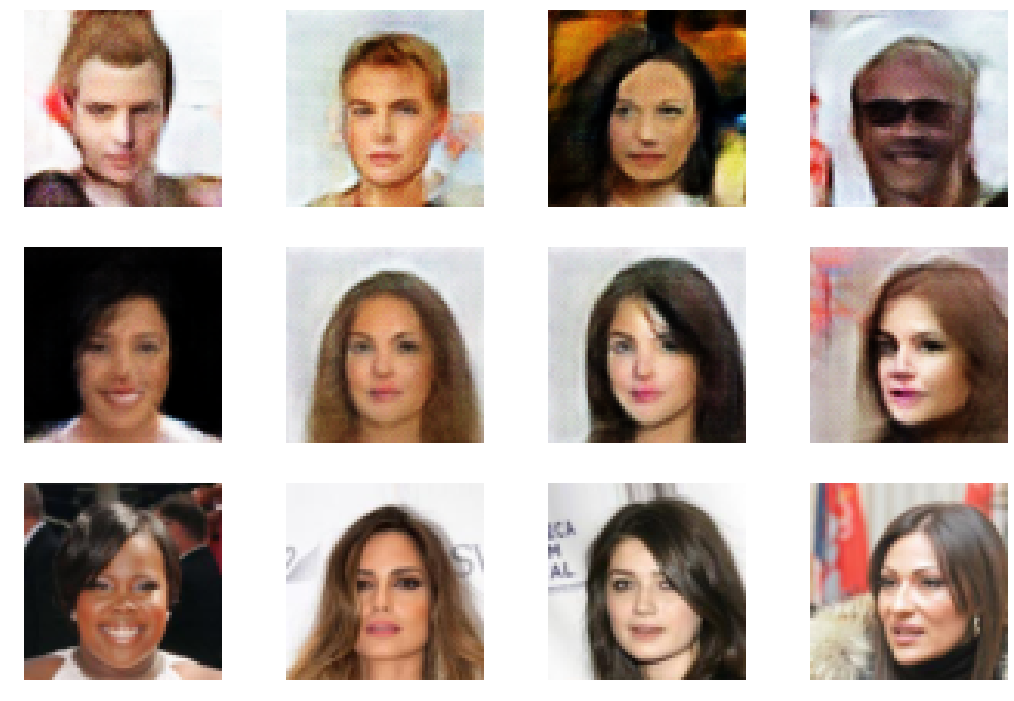

  4%|▍         | 84/1875 [01:50<38:42,  1.30s/it]

In [ ]:
total_batch = int(np.floor(num_examples / batch_size*num_gpus)) # how many batches are in an epoch

# We balance of generator and discriminators learning rate by using a sigmoid function,
#  encouraging the generator and discriminator be about equal
d_real = 0
d_fake = 0

while epoch < num_epochs:    
    for i in tqdm.tqdm(range(total_batch)):
        iter_ = data_iterator()
        # balence gen and descrim
        e_current_lr = e_learning_rate*sigmoid(np.mean(d_real),-.5,15)
        g_current_lr = g_learning_rate*sigmoid(np.mean(d_real),-.5,15)
        d_current_lr = d_learning_rate*sigmoid(np.mean(d_fake),-.5,15)
        next_batches, _ = iter_.next()

        _, _, _, D_err, G_err, KL_err, SSE_err, LL_err, d_fake,d_real = sess.run([
                train_E, train_G, train_D,
                D_loss, G_loss, KL_loss, SSE_loss, LL_loss,
                d_x_p, d_x,

            ],
                                        {
                lr_E: e_current_lr,
                lr_G: g_current_lr,
                lr_D: d_current_lr,
                all_input: next_batches,
                KL_param: 1,
                G_param: 1,
                LL_param: 1
            }
       )
        #KL_err= SSE_err= LL_err = 1
        # Save our lists
        dxp_list.append(d_fake)
        dx_list.append(d_real)
        G_loss_list.append(G_err)
        D_loss_list.append(D_err)
        KL_loss_list.append(KL_err)
        SSE_loss_list.append(SSE_err)
        LL_loss_list.append(LL_err)
    
        if i%300 == 0:
            # print display network output
            IPython.display.clear_output()
            print('Epoch: '+str(epoch))
            plot_network_output()
        
    # save network
    saver.save(sess,''.join(['models/faces_big_VAEGAN_',str(epoch).zfill(4),'.tfmod']))
    epoch +=1


In [ ]:
random_x, recon_x = sess.run((x_p, x_tilde), {all_input: example_data})

In [ ]:
np.shape(recon_x)

In [ ]:
plot_network_output()

In [ ]:
_ = plt.hist(random_x[1])

In [ ]:
_ = plt.hist(example_data[1])

In [ ]:
_ = plt.hist(recon_x[1])

In [ ]:
g_current_lr

In [57]:
random_x, recon_z= sess.run((x_p, z_x), {all_input: example_data})
np.shape(random_x)

(32, 12288)

In [58]:
#np.shape(recon_z)
recon_z= np.random.normal(0,1,(batch_size,hidden_size))

In [59]:
recon_x = sess.run((x_tilde), {z_x: recon_z})

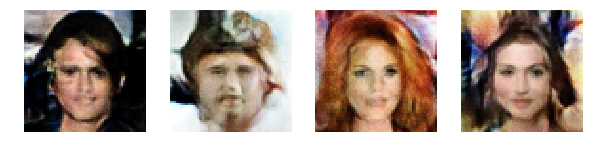

In [60]:
examples = 4
random_x = np.squeeze(random_x)
recon_x = np.squeeze(recon_x)
fig, ax = plt.subplots(nrows=1,ncols=examples, figsize=(10,12))
for i in xrange(examples):
    ax[i].imshow(create_image(recon_x[i]), cmap=plt.cm.gray, interpolation='nearest')
    ax[i].axis('off')
plt.show()

In [90]:
n_steps = 20
all_x_recon = np.zeros((batch_size, dim1*dim2*dim3,n_steps))
recon_z= np.random.normal(0,1,(batch_size,hidden_size))
recon_z2= np.random.normal(0,1,(batch_size,hidden_size))
recon_z_step = (recon_z2 - recon_z)/n_steps
for i in range(n_steps):
    #recon_z_step = np.random.normal(0,.5,(batch_size,400))
    recon_z += recon_z_step
    all_x_recon[:,:,i] = sess.run((x_tilde), {z_x: recon_z})

In [114]:
examples = 4
n_steps = 20
canvas = np.zeros((dim1,dim2*examples,dim3, n_steps))
print np.shape(canvas)
for f in range(n_steps):
    for i in range(examples):
        canvas[:,dim2*i:dim2*(i+1),:,f] = create_image(all_x_recon[i,:,f])
    

(64, 256, 3, 20)


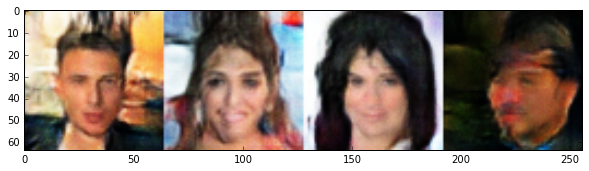

In [120]:
def pltrand2(f):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))
    plt.imshow(canvas[:,:,:,f])
    plt.show()
interact(pltrand2, f = (0,n_steps-1,1))

In [119]:
def pltrand(f):
    examples = 4
    fig, ax = plt.subplots(nrows=1,ncols=examples, figsize=(10,10))
    for i in xrange(examples):
        ax[i].imshow(create_image(all_x_recon[i,:,f]), cmap=plt.cm.gray, interpolation='nearest')
        ax[i].axis('off')
    plt.show()

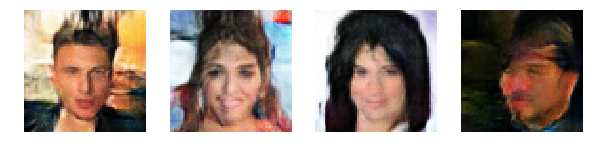

In [92]:
interact(pltrand, f = (0,n_steps-1,1))

In [ ]:
test = create_image(recon_x[i])
#test[test < 0] = 0

In [ ]:
plt.imshow(test)

In [ ]:
np.min(test)

In [ ]:
np.max(test)

In [ ]:
np.min(example_data)

In [ ]:
np.max(example_data)

In [ ]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [ ]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

mywriter = animation.FFMpegWriter()
anim.save('test.mp4',writer=mywriter)

#plt.show()

In [69]:
recon_z= np.random.normal(0,1,(batch_size,400))
recon_x = sess.run((x_tilde), {z_x: recon_z})

In [71]:
for i in range(10):
    rz = np.random.normal(0,1,(batch_size,400))
    recon_z= np.concatenate((recon_z,rz),axis = 0)
    recon_x = np.concatenate((recon_x,sess.run((x_tilde), {z_x: rz})),axis = 0)

IndexError: index 352 is out of bounds for axis 0 with size 352

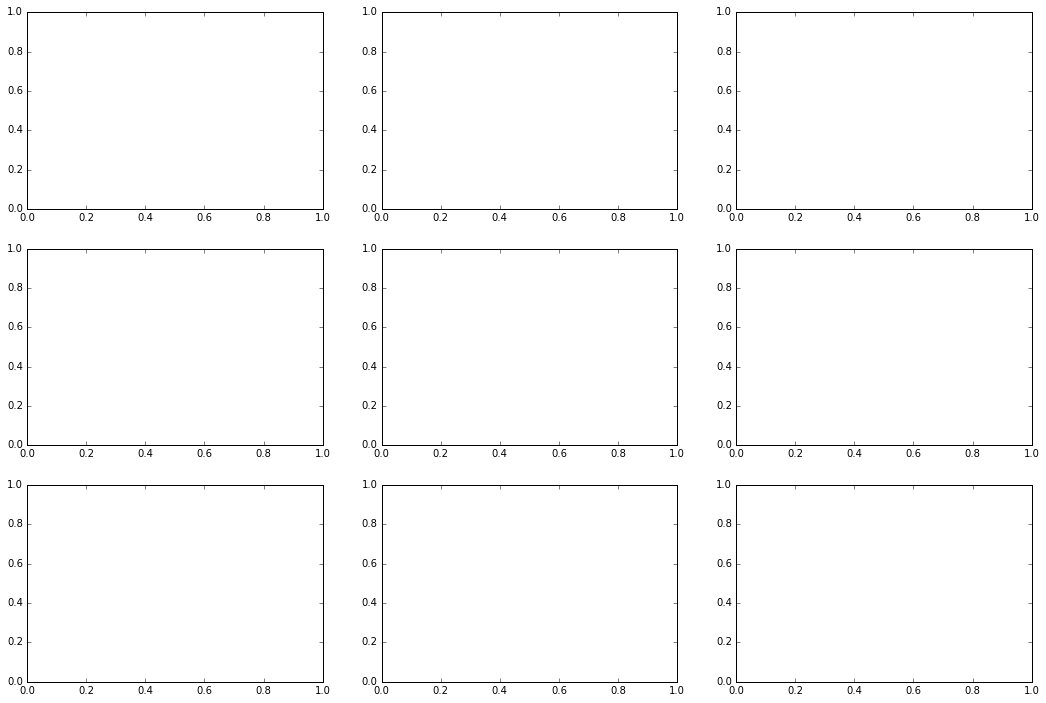

In [86]:
num_neurons = 10

neuron = 0
fig, ax = plt.subplots(nrows=int(np.sqrt(num_neurons)),ncols=int(np.sqrt(num_neurons)), figsize=(18,12))
for a in range(int(np.sqrt(num_neurons))):
    for b in range(int(np.sqrt(num_neurons))):
        proportions = (recon_z[:,neuron] - min(recon_z[:,neuron])) / \
            max((recon_z[:,neuron] - min(recon_z[:,neuron])))
        test = norm(np.sum(([proportions[i] * recon_x[i,:] for i in 
            range(len(proportions))]),axis = 0)/np.sum(proportions)- np.mean(recon_x,axis = 0))
        ax[(a,b)].imshow(create_image(test), cmap=plt.cm.gray, interpolation='nearest')
        ax[(a,b)].axis('off')
        neuron+=1

In [46]:
recon_z= np.random.normal(0,1,(100,400))
recon_x, recon_l = sess.run((x_tilde, l_x_tilde), {z_x: recon_z})

ValueError: Cannot feed value of shape (100, 400) for Tensor u'Tower_0/gen/Add:0', which has shape '(32, 400)'

In [47]:
for i in range(500):
    rz = np.random.normal(0,1,(100,400))
    rx, rl = sess.run((x_tilde, l_x_tilde), {z_x: recon_z})
    recon_l = np.concatenate((recon_l,rl),axis = 0)
    recon_x = np.concatenate((recon_x,rx),axis = 0)

ValueError: Cannot feed value of shape (100, 400) for Tensor u'Tower_0/gen/Add:0', which has shape '(32, 400)'

In [ ]:
num_neurons = 100

neuron = 0
fig, ax = plt.subplots(nrows=int(np.sqrt(num_neurons)),ncols=int(np.sqrt(num_neurons)), figsize=(18,12))
for a in range(int(np.sqrt(num_neurons))):
    for b in range(int(np.sqrt(num_neurons))):
        proportions = (recon_l[:,neuron] - min(recon_l[:,neuron])) / max((recon_l[:,neuron] - min(recon_l[:,neuron])))
        test = norm(np.sum(([proportions[i] * recon_x[i,:] for i in range(len(proportions))]),axis = 0)/np.sum(proportions)- np.mean(recon_x,axis = 0))
        #test = norm(test/np.mean(test_list, axis = 0))
        ax[(a,b)].imshow(create_image(test), cmap=plt.cm.gray, interpolation='nearest')
        ax[(a,b)].axis('off')
        neuron+=1

In [ ]:
_ = plt.hist(np.mean(test_list, axis = 0))

In [ ]:
np.min(test)

In [ ]:
np.shape(recon_x)

In [ ]:
np.max(np.sum(([proportions[i] * recon_x[i,:] for i in range(len(proportions))]),axis = 0)/np.sum(proportions)- np.mean(recon_x,axis = 0))

In [ ]:
np.min(np.sum(([proportions[i] * recon_x[i,:] for i in range(len(proportions))]),axis = 0)/np.sum(proportions)- np.mean(recon_x,axis = 0))

In [ ]:
norm([1.,2.,3.])

In [ ]:
saver.save(sess,''.join(['models/big_faces_working',str(epoch).zfill(4),'.tfmod']))